In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

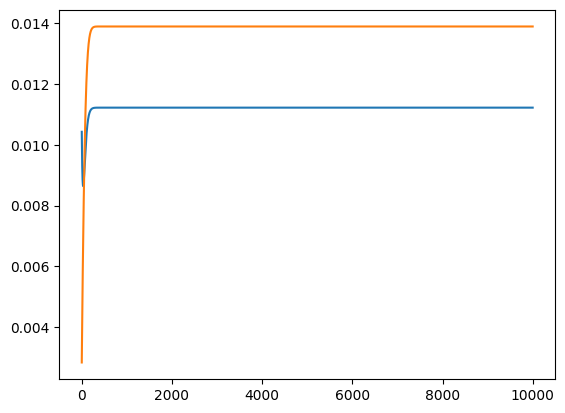

[[0 0]
 [1 0]]


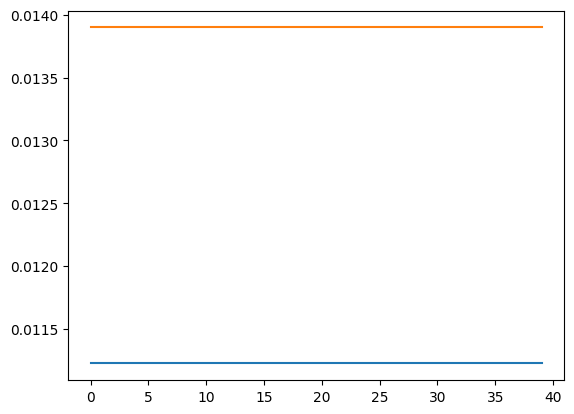

In [370]:
cmat = np.array( [[0., 0.], [1., 0.]] ) # diagonal elements are zero, connection strength is 1 (0.5) from node 0 to node 1 (from node 1 to node 0)
dmat = np.array( [[0., 0.], [0.1, 0.]] ) # delay from 0 to 1, no delay from 1 to 0

model = WCModel(Cmat=cmat, Dmat=dmat)
duration, dt = 1000., 0.1
model.params.duration = duration
model.params.dt = dt
model.params.K_gl = 10.
model.params.signalV = 1.

model.run()

plt.plot(model.exc[0,:])
plt.plot(model.exc[1,:])
plt.show()


e0 = model.exc[0,-1]
e1 = model.exc[1,-1]
i0 = model.inh[0,-1]
i1 = model.inh[1,-1]

model.params["exc_init"] = np.array([[e0, e0, e0],
                                    [e1, e1, e1]])
model.params["inh_init"] = np.array([[i0, i0, i0],
                                     [i1, i1, i1]])

duration = 4.
model.params.duration = duration
time = np.arange(dt, duration+dt, dt)

model.run()

print(model.params.Dmat_ndt)

plt.plot(model.exc[0,:])
plt.plot(model.exc[1,:])
plt.show()

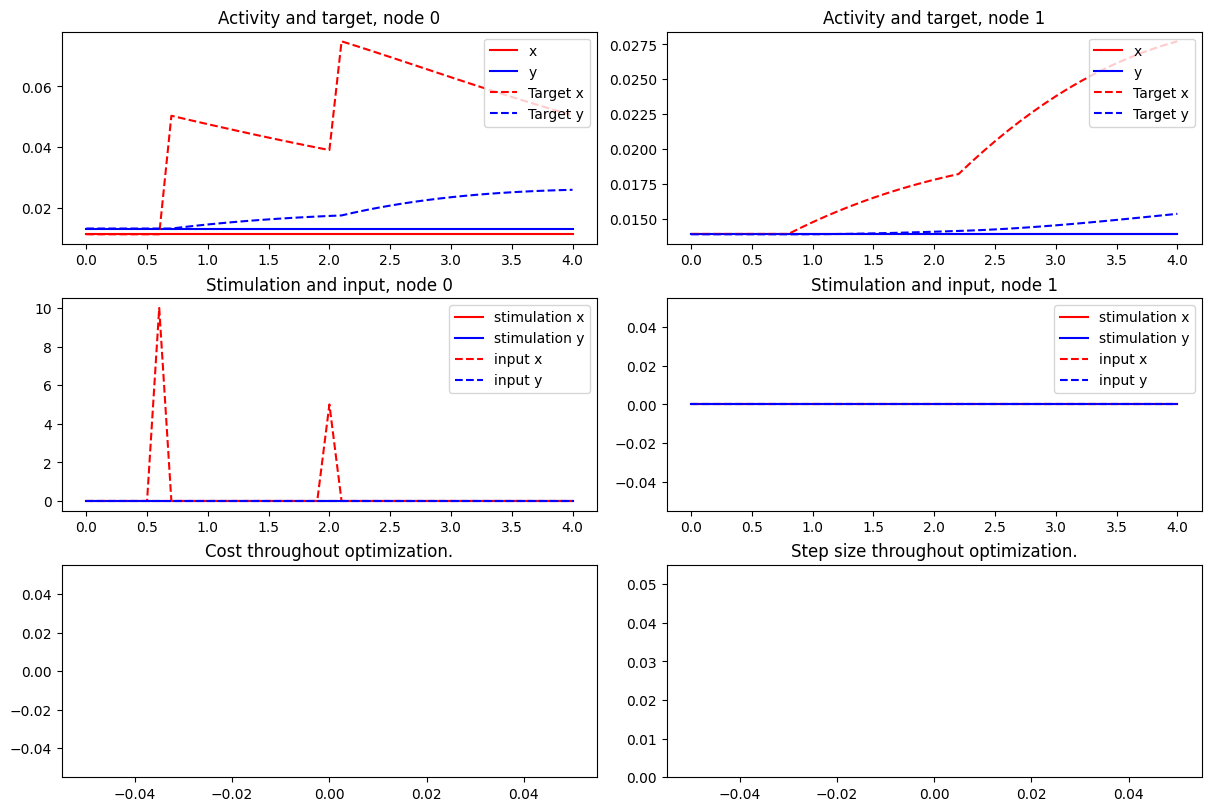

In [364]:
# we define the control input matrix to enable or disable certain channels and nodes
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1. # only allow inputs in E-channel in node 0

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
input = zero_input.copy()
input[0,6] = 10. # other functions or random values can be used as well
input[0,20] = 5.
#input[0,26] = 1.

input_nw = np.concatenate( (np.vstack( [control_mat[0,0] * input, control_mat[0,1] * input] )[np.newaxis,:,:],
                            np.vstack( [control_mat[1,0] * input, control_mat[1,1] * input] )[np.newaxis,:,:]), axis=0)
zero_input_nw = np.concatenate( (np.vstack( [zero_input, zero_input] )[np.newaxis,:,:],
                                 np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]), axis=0)

model.params["exc_ext"] = input_nw[:,0,:]
model.params["inh_ext"] = input_nw[:,1,:]

model.run()
# Define the result of the stimulation as target
target = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

# Remove stimuli and re-run the simulation
model.params["exc_ext"] = zero_input_nw[:,0,:]
model.params["inh_ext"] = zero_input_nw[:,0,:]
model.run()

# combine initial value and simulation result to one array
state = np.concatenate( (np.stack( (model.params["exc_init"][:,-1], model.params["inh_init"][:,-1]), axis=1)[:,:, np.newaxis], np.stack( (model.exc, model.inh), axis=1)), axis=2)

plot_oc_network(model.params.N, duration, dt, state, target, zero_input_nw, input_nw)

Compute control for a deterministic system
Cost in iteration 0: 0.00010640680802866398
Cost in iteration 1: 9.798168736218179e-05
Cost in iteration 2: 1.641283541917134e-05
Cost in iteration 10: 6.132742530606717e-07
Cost in iteration 50: 2.9201797510851594e-07
Cost in iteration 100: 1.8743759759023694e-07
Final cost : 1.8743759759023694e-07


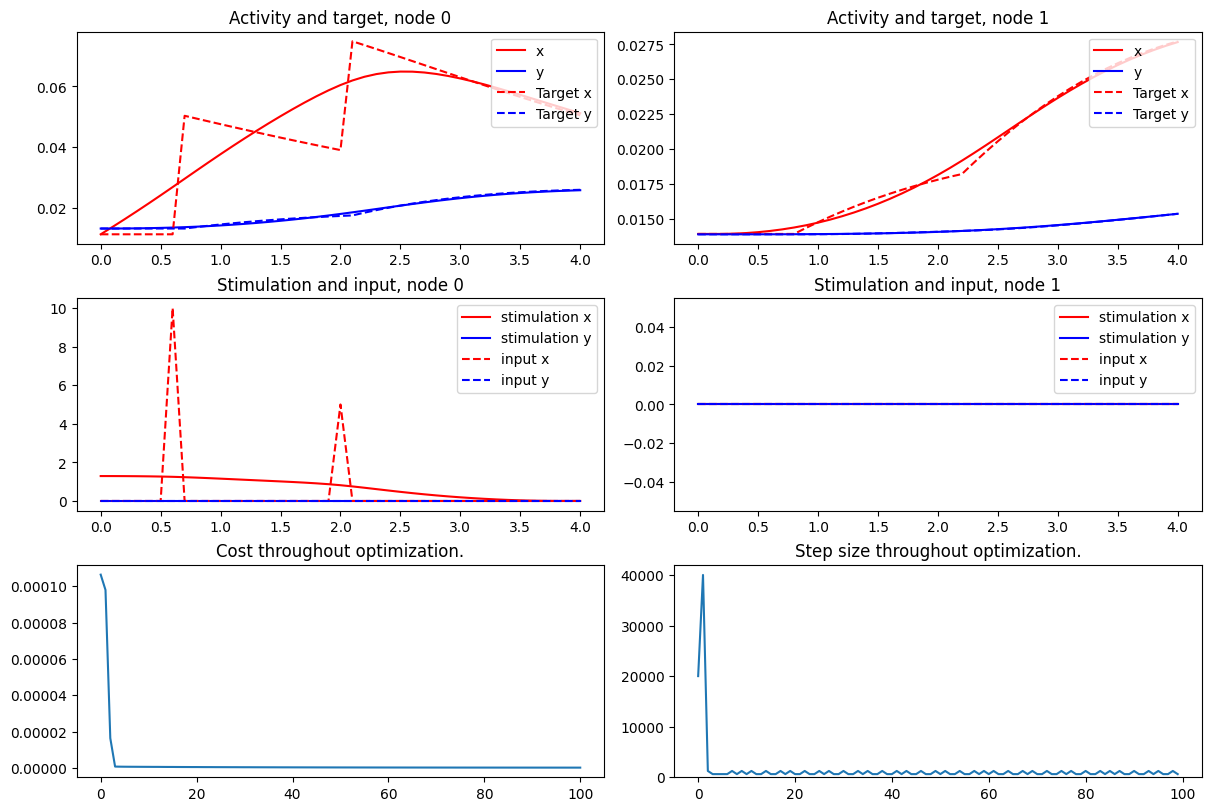

In [365]:
prec_mat = np.zeros( (model.params.N, len(model.output_vars)) )
prec_mat[1,0] = 1. # only measure in y-channel in node 1

model_controlled = oc_wc.OcWc(model, target, w_p=1, w_2=0, print_array=[1,2,10,50,100,200,300,400,500], control_matrix=control_mat, precision_matrix=prec_mat)

model_controlled.step = 1e4
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

Compute control for a deterministic system
Cost in iteration 0: 1.9503813241825272e-09
Cost in iteration 1: 1.9503398432586e-09
Cost in iteration 2: 1.9503097557239893e-09
Cost in iteration 10: 1.9498663122065782e-09
Cost in iteration 50: 1.947814683398104e-09
Cost in iteration 100: 1.9453526531481044e-09
Cost in iteration 200: 1.9403186784558094e-09
Cost in iteration 300: 1.9353717598370364e-09
Cost in iteration 400: 1.9304838862920842e-09
Cost in iteration 500: 1.925620998377966e-09
Final cost : 8.165032647287219e-10


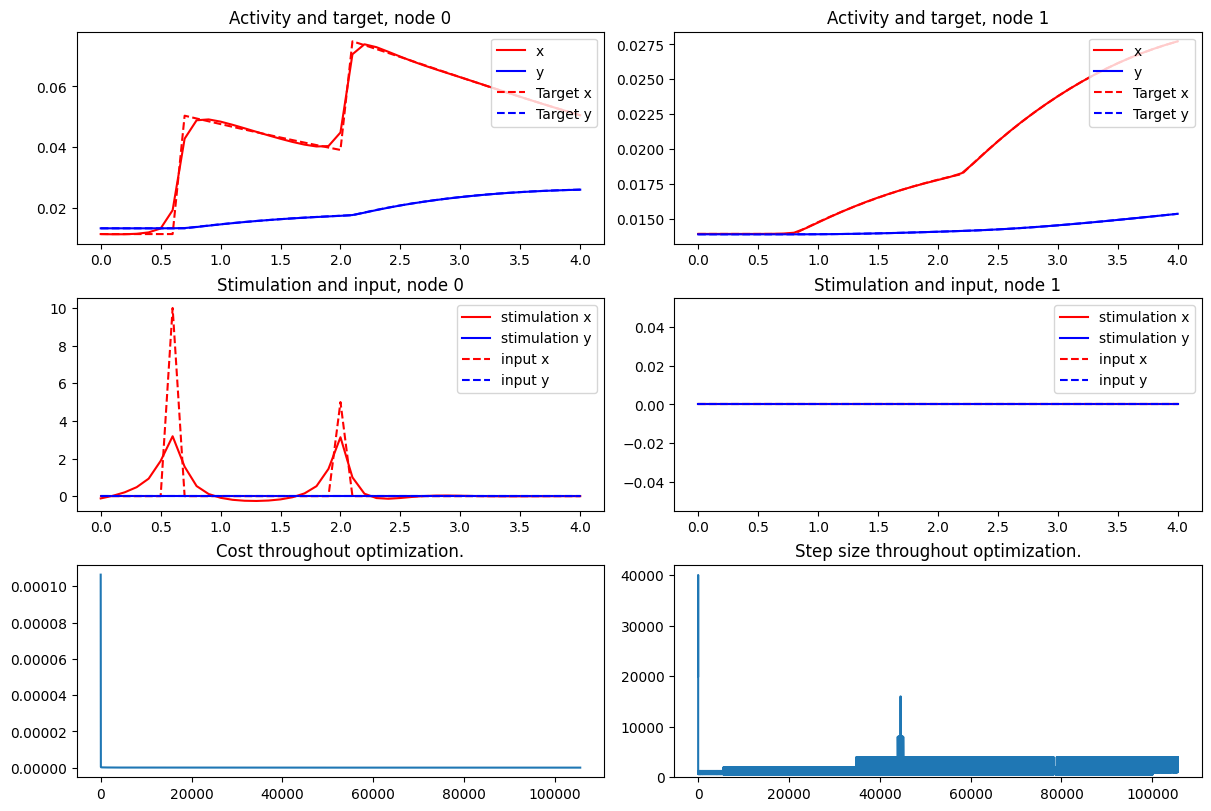

In [369]:
# Do another 100 iterations if you want to.
# Repeated execution will continue with further 100 iterations.
for k in range(1):
    model_controlled.step = 1e3
    model_controlled.optimize(50000)
    state = model_controlled.get_xs()
    control = model_controlled.control
    plot_oc_network(model.params.N, duration, dt, state, target, control, input_nw, model_controlled.cost_history, model_controlled.step_sizes_history)

# 1.1201023065204033e-05

In [268]:

model_controlled.step = 1e-4
model_controlled.optimize(1)

Compute control for a deterministic system
Cost in iteration 0: 1.8640282699091613e-09
Converged in iteration 1 with cost 1.8640282699091613e-09
Final cost : 1.8640282699091613e-09


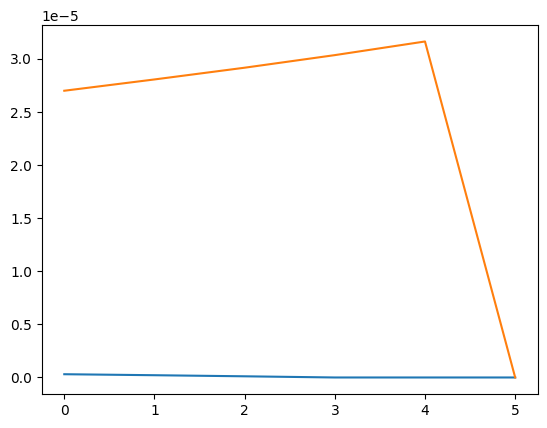

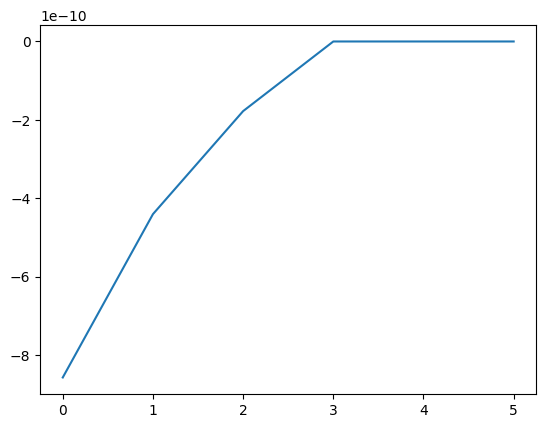

In [290]:
plt.plot(model_controlled.adjoint_state[0,0,:])
plt.plot(model_controlled.adjoint_state[1,0,:])
plt.show()

plt.plot(model_controlled.gradient[0,0,:])
plt.show()